In [2]:
import tarfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Handle the dataset

### extract the compressed dataset

In [ ]:
# Extract the .tar.gz file
with tarfile.open('hw1-data.tar.gz', 'r:gz') as archive:
    archive.extractall()  # The folder where the contents will be extracted

### load data

In [4]:
# Define the transformations for the images (resize, normalize, etc.)
train_transform = transforms.Compose([
    transforms.autoaugment.AutoAugment(),  # AutoAugment
    transforms.RandomResizedCrop(224),  # Crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # Normalize images
])

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.Resize(256),  # Resize all images to 256x256
    transforms.CenterCrop(224),  # Crop to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # Normalize images
])

# Define the path to the extracted data folder
data_dir = 'data'

# Load datasets from the respective directories (train, valid, test)
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    transform=train_transform
)

valid_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    transform=transform
)

# Create DataLoader objects for batching and shuffling the data
train_loader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, num_workers=4
)

valid_loader = DataLoader(
    valid_dataset, batch_size=32,
    shuffle=False, num_workers=4
)

for images, labels in train_loader:
    print(labels)
    print(images.shape, labels.shape)
    break

tensor([61,  5, 70, 88, 81,  8, 70, 87,  2, 23, 40, 73, 32,  3, 72, 26, 54,  4,
         5, 38, 11, 98, 15, 96,  8, 90, 45, 43, 35, 38, 38, 68])
torch.Size([32, 3, 224, 224]) torch.Size([32])


# Training

### Load pretrained ResNet

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_model():
    model = models.resnext101_64x4d(pretrained=True)

    # Freeze the first two layers
    for name, param in model.named_parameters():
        if name.startswith("layer1"):
            param.requires_grad = False

    # Modify the fully connected layer for new number of classes
    num_ftrs = model.fc.in_features
    num_classes = 100
    model.fc = nn.Linear(num_ftrs, num_classes)

    '''
    print(torch.cuda.is_available())
    print(torch.version.cuda)
    print(torch.backends.cudnn.enabled)
    '''

    model = model.to(device)

    # calculate the number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    return model

Using device: cuda:1


### train process

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


def train(model, optimizer, scheduler, criterion, epochs=10):
    best_acc = 0
    best_model_loss = np.inf
    for epoch in range(epochs):
        # training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")
        # scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = correct / total
        train_accuracies.append(acc)
        print(f"Epoch {epoch + 1}, Training Accuracy: {acc}")

        # validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        loss = running_loss / len(valid_loader)
        val_losses.append(loss)
        acc = correct / total
        val_accuracies.append(acc)
        print(f"Epoch {epoch + 1}, Validation Loss: {loss}")
        print(f"Epoch {epoch + 1}, Validation Accuracy: {acc}")

        if acc > best_acc:
            best_acc = acc
            best_model_loss = train_loss
            torch.save(model.state_dict(),
                       f'./checkpoint/ResNeXt101_64x4d{epoch+1}.pth')
            print(f"Epoch {epoch + 1}, Accuracy: {acc}")
            print(f"Best model so far with accuracy: {best_acc}")
        elif acc == best_acc and train_loss < best_model_loss:
            best_model_loss = train_loss
            torch.save(model.state_dict(),
                       f'./checkpoint/ResNeXt101_64x4d_epoch{epoch+1}.pth')
            print(f"Epoch {epoch + 1}, Accuracy: {acc}")
            print(f"Best model so far with accuracy: {best_acc}\n")

        '''
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
            print(f"Epoch {epoch + 1}, Accuracy: {acc}")'
        '''

In [11]:
model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00008)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train(model, optimizer, scheduler, criterion, epochs=20)

Total parameters: 81611172
Trainable parameters: 81217956


100%|██████████| 648/648 [02:28<00:00,  4.35it/s]

Epoch 1, Training Loss: 2.1235260219301706


Epoch 1, Training Accuracy: 0.798108473267709
Epoch 1, Validation Loss: 0.8838907182216644
Epoch 1, Validation Accuracy: 0.78
Epoch 1, Accuracy: 0.78
Best model so far with accuracy: 0.78


100%|██████████| 648/648 [02:28<00:00,  4.37it/s]

Epoch 2, Training Loss: 0.7978725363442927


Epoch 2, Training Accuracy: 0.8677378884385254
Epoch 2, Validation Loss: 0.5911752272397279
Epoch 2, Validation Accuracy: 0.8466666666666667
Epoch 2, Accuracy: 0.8466666666666667
Best model so far with accuracy: 0.8466666666666667


100%|██████████| 648/648 [02:28<00:00,  4.37it/s]

Epoch 3, Training Loss: 0.6093605371583023


Epoch 3, Training Accuracy: 0.885060799073538
Epoch 3, Validation Loss: 0.5356377646327019
Epoch 3, Validation Accuracy: 0.8733333333333333
Epoch 3, Accuracy: 0.8733333333333333
Best model so far with accuracy: 0.8733333333333333


100%|██████████| 648/648 [02:28<00:00,  4.35it/s]

Epoch 4, Training Loss: 0.5185046980019521


Epoch 4, Training Accuracy: 0.8986682107701216
Epoch 4, Validation Loss: 0.5022690299898386
Epoch 4, Validation Accuracy: 0.8666666666666667


100%|██████████| 648/648 [02:29<00:00,  4.35it/s]

Epoch 5, Training Loss: 0.46181466309698643


Epoch 5, Training Accuracy: 0.9164736537348003
Epoch 5, Validation Loss: 0.43309608697891233
Epoch 5, Validation Accuracy: 0.88
Epoch 5, Accuracy: 0.88
Best model so far with accuracy: 0.88


100%|██████████| 648/648 [02:29<00:00,  4.33it/s]

Epoch 6, Training Loss: 0.414469285885355


Epoch 6, Training Accuracy: 0.916377147268867
Epoch 6, Validation Loss: 0.44391513308510183
Epoch 6, Validation Accuracy: 0.8933333333333333
Epoch 6, Accuracy: 0.8933333333333333
Best model so far with accuracy: 0.8933333333333333


100%|██████████| 648/648 [02:29<00:00,  4.33it/s]


Epoch 7, Training Loss: 0.3889179024098004
Epoch 7, Training Accuracy: 0.9249662227369234
Epoch 7, Validation Loss: 0.43623212426900865
Epoch 7, Validation Accuracy: 0.8766666666666667


100%|██████████| 648/648 [02:29<00:00,  4.34it/s]


Epoch 8, Training Loss: 0.346808439500078
Epoch 8, Training Accuracy: 0.9319629415170817
Epoch 8, Validation Loss: 0.4256652969866991
Epoch 8, Validation Accuracy: 0.8966666666666666
Epoch 8, Accuracy: 0.8966666666666666
Best model so far with accuracy: 0.8966666666666666


100%|██████████| 648/648 [02:30<00:00,  4.30it/s]

Epoch 9, Training Loss: 0.34799691616488554


Epoch 9, Training Accuracy: 0.9330727658753136
Epoch 9, Validation Loss: 0.433259567245841
Epoch 9, Validation Accuracy: 0.9
Epoch 9, Accuracy: 0.9
Best model so far with accuracy: 0.9


100%|██████████| 648/648 [02:30<00:00,  4.32it/s]

Epoch 10, Training Loss: 0.31719010569051737


Epoch 10, Training Accuracy: 0.9324454738467477
Epoch 10, Validation Loss: 0.5044368132948875
Epoch 10, Validation Accuracy: 0.87


100%|██████████| 648/648 [02:28<00:00,  4.36it/s]

Epoch 11, Training Loss: 0.313496927736488


Epoch 11, Training Accuracy: 0.935871453387377
Epoch 11, Validation Loss: 0.4825778242200613
Epoch 11, Validation Accuracy: 0.89


100%|██████████| 648/648 [02:30<00:00,  4.30it/s]

Epoch 12, Training Loss: 0.29176491906831936


Epoch 12, Training Accuracy: 0.9422891333719359
Epoch 12, Validation Loss: 0.42407388985157013
Epoch 12, Validation Accuracy: 0.8833333333333333


100%|██████████| 648/648 [02:31<00:00,  4.27it/s]

Epoch 13, Training Loss: 0.2866299013308261


Epoch 13, Training Accuracy: 0.9405037637521714
Epoch 13, Validation Loss: 0.5010240342468023
Epoch 13, Validation Accuracy: 0.8666666666666667


100%|██████████| 648/648 [02:29<00:00,  4.35it/s]


Epoch 14, Training Loss: 0.2841614198994558
Epoch 14, Training Accuracy: 0.9412275622466705
Epoch 14, Validation Loss: 0.4617083297111094
Epoch 14, Validation Accuracy: 0.8866666666666667


100%|██████████| 648/648 [02:30<00:00,  4.31it/s]

Epoch 15, Training Loss: 0.26674191151849097


Epoch 15, Training Accuracy: 0.9377533294730747
Epoch 15, Validation Loss: 0.5589854060672224
Epoch 15, Validation Accuracy: 0.8733333333333333


100%|██████████| 648/648 [02:29<00:00,  4.32it/s]

Epoch 16, Training Loss: 0.25585301239675856


Epoch 16, Training Accuracy: 0.9445570353213665
Epoch 16, Validation Loss: 0.4561361812055111
Epoch 16, Validation Accuracy: 0.9
Epoch 16, Accuracy: 0.9
Best model so far with accuracy: 0.9



100%|██████████| 648/648 [02:30<00:00,  4.32it/s]

Epoch 17, Training Loss: 0.25983015712879504


Epoch 17, Training Accuracy: 0.9475004825323297
Epoch 17, Validation Loss: 0.4594911134801805
Epoch 17, Validation Accuracy: 0.9


100%|██████████| 648/648 [02:31<00:00,  4.27it/s]

Epoch 18, Training Loss: 0.2496007231975342


Epoch 18, Training Accuracy: 0.9466319243389307
Epoch 18, Validation Loss: 0.4424394767731428
Epoch 18, Validation Accuracy: 0.9
Epoch 18, Accuracy: 0.9
Best model so far with accuracy: 0.9



100%|██████████| 648/648 [02:29<00:00,  4.34it/s]

Epoch 19, Training Loss: 0.24620330819851477


Epoch 19, Training Accuracy: 0.9477417486971627
Epoch 19, Validation Loss: 0.42388447737321255
Epoch 19, Validation Accuracy: 0.91
Epoch 19, Accuracy: 0.91
Best model so far with accuracy: 0.91


100%|██████████| 648/648 [02:29<00:00,  4.32it/s]

Epoch 20, Training Loss: 0.23490986987850687


Epoch 20, Training Accuracy: 0.9484172939586952
Epoch 20, Validation Loss: 0.46377224400639533
Epoch 20, Validation Accuracy: 0.8933333333333333


### plot learning curve

[2.1235260219301706, 0.7978725363442927, 0.6093605371583023, 0.5185046980019521, 0.46181466309698643, 0.414469285885355, 0.3889179024098004, 0.346808439500078, 0.34799691616488554, 0.31719010569051737, 0.313496927736488, 0.29176491906831936, 0.2866299013308261, 0.2841614198994558, 0.26674191151849097, 0.25585301239675856, 0.25983015712879504, 0.2496007231975342, 0.24620330819851477, 0.23490986987850687]
[0.798108473267709, 0.8677378884385254, 0.885060799073538, 0.8986682107701216, 0.9164736537348003, 0.916377147268867, 0.9249662227369234, 0.9319629415170817, 0.9330727658753136, 0.9324454738467477, 0.935871453387377, 0.9422891333719359, 0.9405037637521714, 0.9412275622466705, 0.9377533294730747, 0.9445570353213665, 0.9475004825323297, 0.9466319243389307, 0.9477417486971627, 0.9484172939586952]
[0.8838907182216644, 0.5911752272397279, 0.5356377646327019, 0.5022690299898386, 0.43309608697891233, 0.44391513308510183, 0.43623212426900865, 0.4256652969866991, 0.433259567245841, 0.50443681329

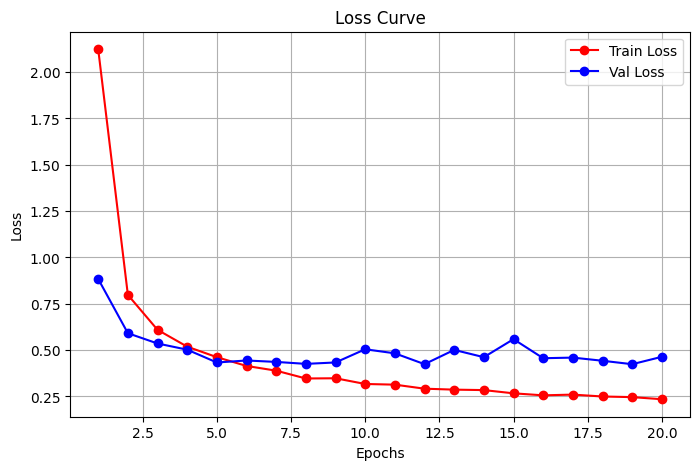

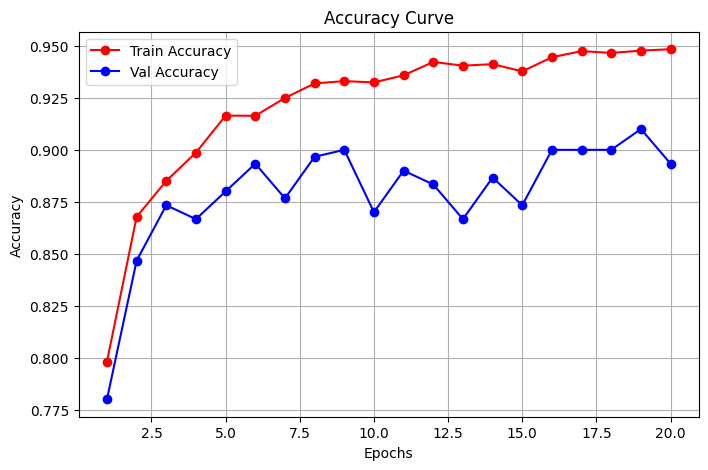

In [ ]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_losses,
         label='Train Loss', marker='o', color='red')
plt.plot(range(1, 21), val_losses, label='Val Loss', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_accuracies,
         label='Train Accuracy', marker='o', color='red')
plt.plot(range(1, 21), val_accuracies,
         label='Val Accuracy', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid()
plt.show()

# Testing

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(test_dir)
                                   if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)

        file_name = os.path.splitext(img_name)[0]

        # Load image
        image = Image.open(img_path)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, file_name

In [ ]:
test_dataset = TestDataset("./data/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=4)

In [ ]:
model = models.resnext101_64x4d(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_path = './checkpoint/ResNeXt101_64x4d19.pth'
model.load_state_dict(torch.load(model_path))

model.eval()
class_name = train_dataset.classes
predictions = []
filenames = []
with torch.no_grad():
    for images, file_names in tqdm(test_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class
        _, preds = torch.max(outputs, 1)

        # Map predicted indices to class names
        predicted_labels = [class_name[p]
                            for p in preds.cpu().numpy()]

        # Convert predictions and filenames to lists
        predictions.extend(predicted_labels)
        filenames.extend(file_names)

# Create DataFrame
results_df = pd.DataFrame({
    'image_name': filenames,
    'pred_label': predictions
})

'''
# Save to CSV
output_csv = 'prediction.csv'
results_df.to_csv(output_csv, index=False)
print(f"Predictions saved to {output_csv}")'
'''


/home/kwchiu/anaconda3/envs/PRDL/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kwchiu/anaconda3/envs/PRDL/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/tmp/ipykernel_37275/2305133467.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 74/74 [00:09<00:00,  8.10i

Predictions saved to prediction.csv


### plot confusion matrix

/tmp/ipykernel_4066271/2986611459.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 10/10 [00:03<00:00,  3.1

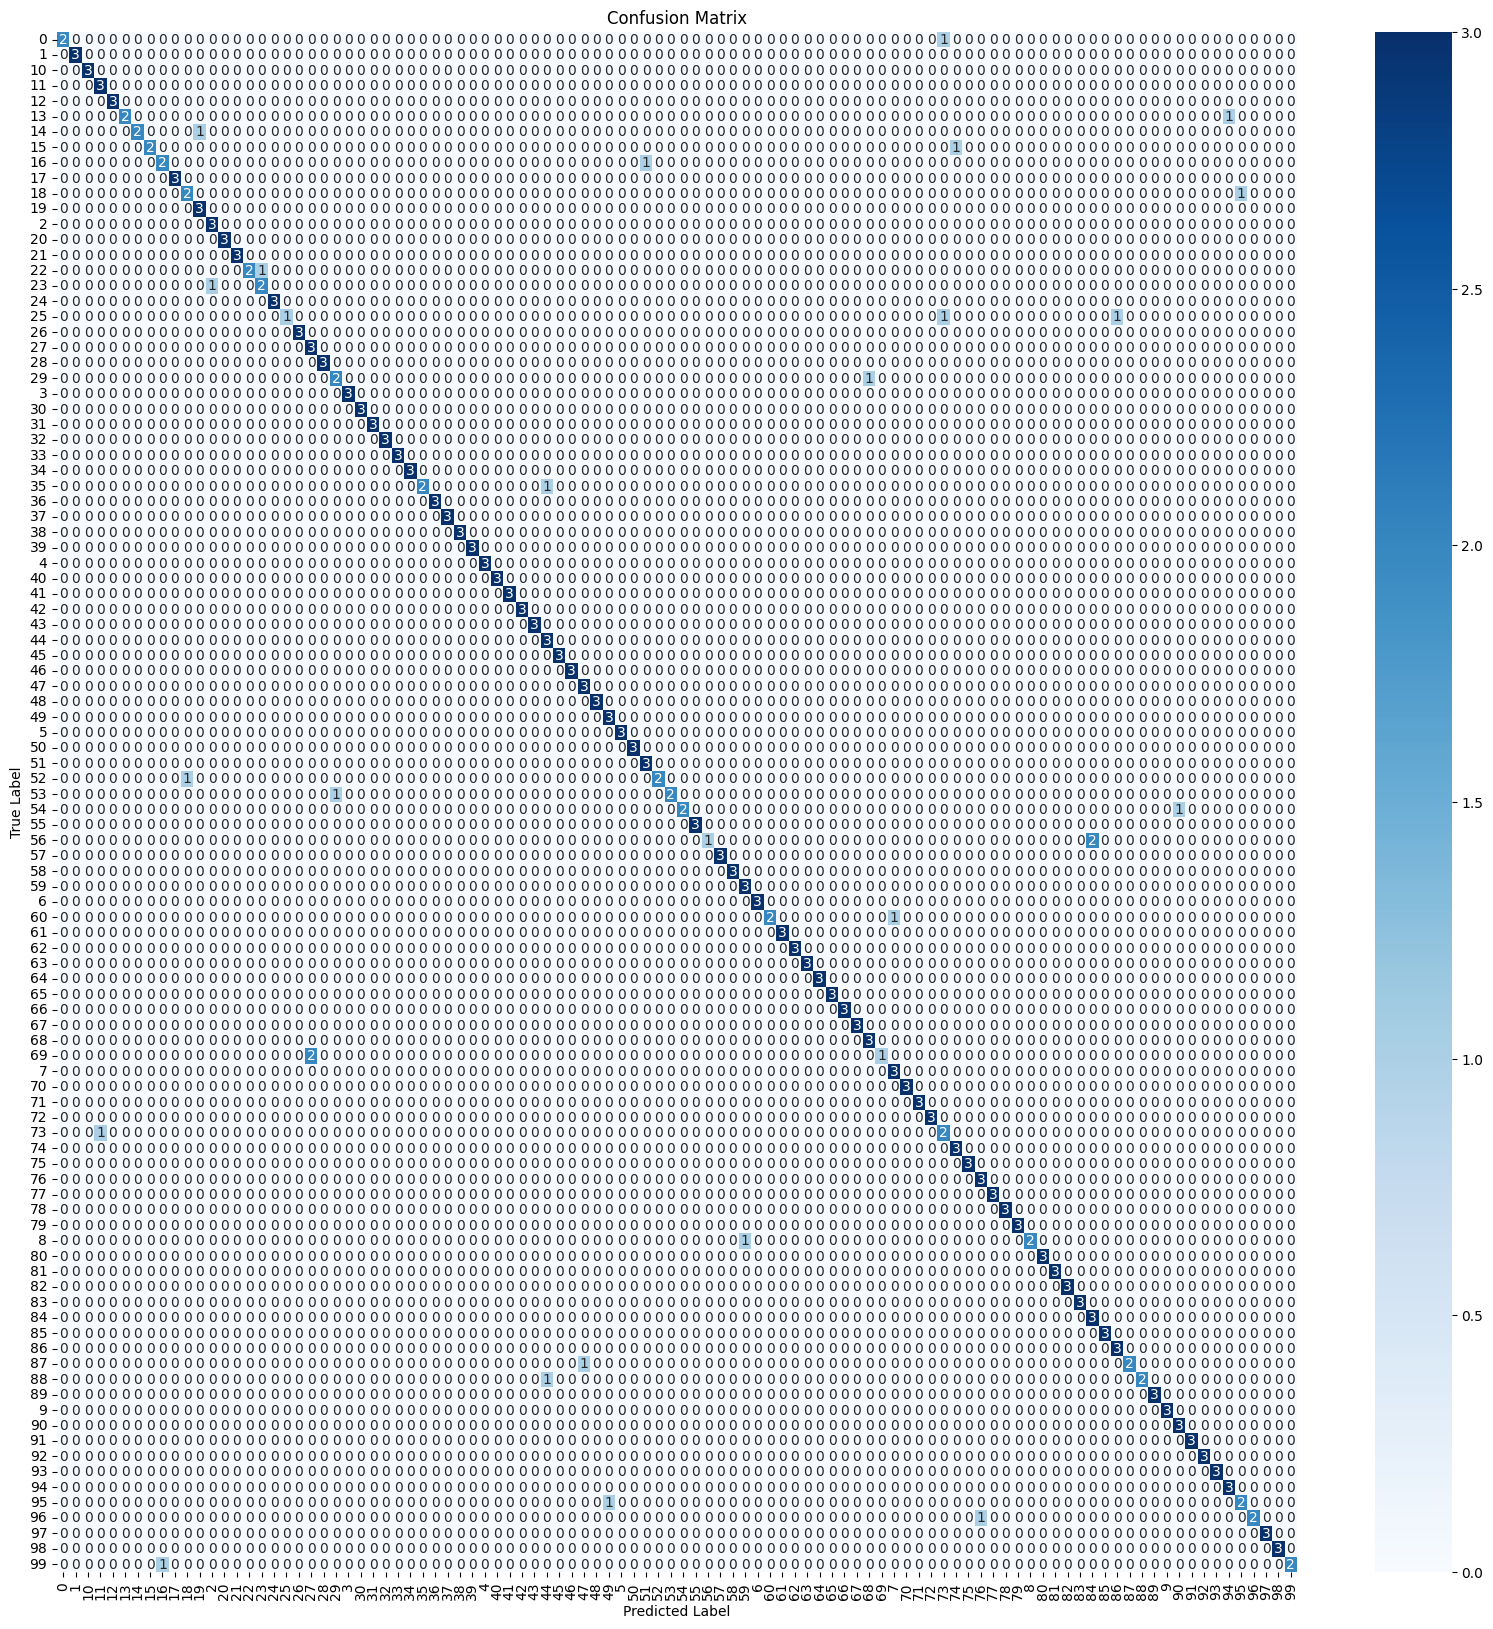

In [5]:
model = models.resnext101_64x4d(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = 100
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_path = './checkpoint/ResNeXt101_64x4d19.pth'
model.load_state_dict(torch.load(model_path))

model.eval()
class_name = train_dataset.classes
predictions = []
filenames = []
with torch.no_grad():
    for images, file_names in tqdm(valid_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class
        _, preds = torch.max(outputs, 1)

        # Map predicted indices to class names
        predicted_labels = [class_name[p]
                            for p in preds.cpu().numpy()]

        # Convert predictions and filenames to lists
        predictions.extend(predicted_labels)
        filenames.extend(file_names)

# Load ground truth labels
true_labels = []
for images, labels in valid_loader:
    true_labels.extend(labels.numpy())  # Store actual labels

# Convert predicted class names back to indices
predicted_indices = [class_name.index(pred) for pred in predictions]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_indices)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
